In [1]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme, run_experiment)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model, get_direct_custom_layer,
                           get_custom_layer, get_extended_custom_layer)
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, 
                  save_object, load_object)
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)
from IPython.display import clear_output

# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [51]:
def add_dense_head(x, final_activation="exponential"):
    outs = []
    
    for i in range(9):
        out_qi = Dense(1, name="q{}".format(i), activation=final_activation)(x)
        outs.append(out_qi)
    
    return outs


def add_dist2_head(x, final_activation="exponential", sigma_coefs=None):
    if sigma_coefs is None:
        sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

    mu = Dense(1, activation=final_activation, name="mu")(x)  # represents mu
    sigma = Dense(1, activation=final_activation, name="sigma")(x)  # represents sigma

    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)
    
    return outs


def add_dist4_head(x, final_activation="exponential", sigma_coefs=None):
    if sigma_coefs is None:
        sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

    mu = Dense(1, activation=final_activation, name="mu")(x)  # represents mu
    sigma = Dense(1, activation=final_activation, name="sigma")(x)  # represents sigma
    kurtosis = Dense(1, name="kurtosis")(x)  # represents kurtosis
    skewness = Dense(1, name="skewness")(x)  # represents skewness
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_extended_custom_layer(sigma_coefs=sigma_coefs, i=i)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma, kurtosis, skewness])
        outs.append(out_q)
    
    return outs


def add_direct_head(x, final_activation=None):
    # final activation parameter only for compatibility

    # direct prediction of median
    qm = Dense(1, name="q4", activation="exponential")(x)

    # setup parameters
    alpha = Dense(1, name="alpha", activation="sigmoid")(x)
    beta = Dense(1, name="beta", activation="sigmoid")(x)
    gamma = Dense(1, name="gamma", activation="sigmoid")(x)
    delta = Dense(1, name="delta", activation="exponential")(x)
    epsilon = Dense(1, name="epsilon", activation="sigmoid")(x)
    zeta = Dense(1, name="zeta", activation="sigmoid")(x)
    eta = Dense(1, name="eta", activation="sigmoid")(x)
    theta = Dense(1, name="theta", activation="sigmoid")(x)

    outs = []

    for i in range(9):
        if i == 4:
            out_q = qm
        else:
            custom_layer = get_direct_custom_layer(i)
            params = [qm, alpha, beta, gamma, delta, epsilon, zeta, eta, theta]
            out_q = Lambda(custom_layer, name="q{}".format(i))(params)
        outs.append(out_q)

    return outs


# Train MLP - trechter architecture

In [3]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [4]:
model_dir = 'models/uncertainty/trechter_architecture/tr2-run1/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [29]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

augment_events = False
lgb_prediction_dir = 'models/uncertainty/train_lightgbm_events/run1/'
lgb_prediction = True
if lgb_prediction:
    # add one to the input shape
    for key, val in input_shapes.items():
        input_shapes[key] = (val[0]+1,)

# Set initial batch size
warmup_batch_size = {level: 64 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 256 if level <= 9 else 25000 for level in range(1, 1+12)}

In [6]:
def get_trechter_node_list(num_nodes_start=256, num_nodes_end=8, num_layers=4, exponent=1/3, verbose=True):
    nodes_list = []
    for i in range(num_layers+1):
        num = num_nodes_start + (i / num_layers)**exponent * (num_nodes_end - num_nodes_start)
        nodes_list.append(int(num))
    print("Trechter nodes: ", nodes_list) if verbose else None
    return nodes_list

get_trechter_node_list()

Trechter nodes:  [256, 99, 59, 30, 8]


[256, 99, 59, 30, 8]

In [44]:
def get_dense_block(x, nodes_list, dropout_rate=0, dropout_layers=[2, 4]):
    for i, num in enumerate(nodes_list):
        x = Dense(num, activation="relu")(x)
        if dropout_rate > 0 and i in dropout_layers:
            x = Dropout(rate=dropout_rate)(x)
    return x


def get_trechter_model(inp_shape, num_nodes_start=256, num_nodes_end=8, num_layers=4, 
                       dropout_rate=0, dropout_layers=[2, 4], mode="dense", clear_session=True):
    if clear_session:
        # clear previous sessions
        K.clear_session()
    
    inp = Input(inp_shape, name="input")
    x = inp
    
    nodes_list = get_trechter_node_list(num_nodes_start, num_nodes_end, num_layers)
    x = get_dense_block(x, nodes_list, dropout_rate=dropout_rate, dropout_layers=dropout_layers)
    
    # add custom layer head
    if mode == "dense":
        outs = add_dense_head(x)
    elif mode == "dist2":
        outs = add_dist2_head(x)
    if mode == "dist4":
        outs = add_dist4_head(x)
    if mode == "direct":
        outs = add_direct_head(x)

    model = Model(inputs=inp, outputs=outs)

    return model

## Test run

In [45]:
level = 3
n0 = input_shapes[level][0] // 8

Trechter nodes:  [24, 11, 8, 5, 4]


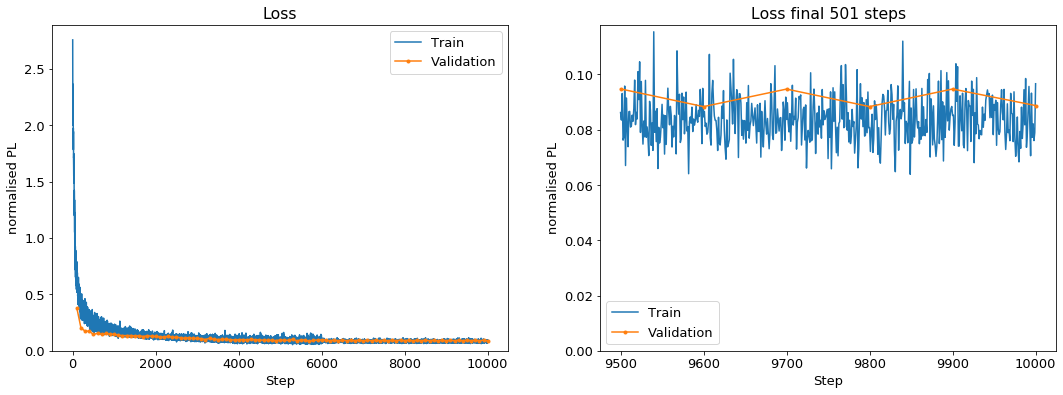

100/100 [==============================] - 3s 31ms/step - loss: 0.0841 - q0_loss: 9.6986e-04 - q1_loss: 0.0032 - q2_loss: 0.0111 - q3_loss: 0.0136 - q4_loss: 0.0183 - q5_loss: 0.0160 - q6_loss: 0.0139 - q7_loss: 0.0053 - q8_loss: 0.0017 - val_loss: 0.0887 - val_q0_loss: 8.8831e-04 - val_q1_loss: 0.0026 - val_q2_loss: 0.0087 - val_q3_loss: 0.0127 - val_q4_loss: 0.0206 - val_q5_loss: 0.0189 - val_q6_loss: 0.0171 - val_q7_loss: 0.0058 - val_q8_loss: 0.0015
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.17716994694037325, 'WSPL': 0.17716994694037325}


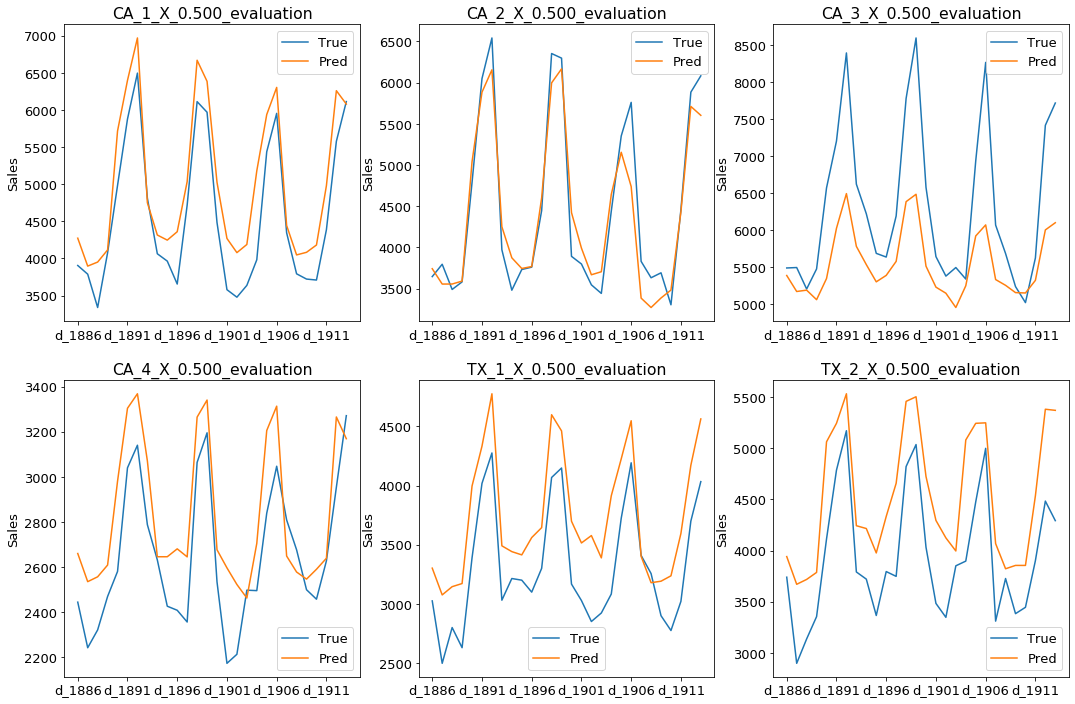

In [39]:
model = get_trechter_model(inp_shape=input_shapes[level], num_nodes_start=n0, num_nodes_end=6, dropout_rate=0.2,
                          mode="direct")

model_name = "model_test_run"
augment_events = False

# train model
warmup_lr_list = [1e-3, 1e-3, 1e-3,  # save part 1
                  1e-3, 1e-3, 1e-3]  # save part 2
finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5] # save part 3
model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
    level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
    model_dir=model_dir, model_name=model_name, warmup_lr_list=warmup_lr_list,
    finetune_lr_list=finetune_lr_list, lgb_prediction=lgb_prediction,
    lgb_prediction_dir=lgb_prediction_dir, augment_events=augment_events,
)

## Define networks

Hyperparameters: 
- custom layers: `["dense", "dist2", "dist4", "direct"]`
- n0: `[8, 16, 24, 32, 48, 64, 128, 256]`
- n1: `[2, 4, 6, 8, 12, 16, 24, 32, 48, 64]`
- dropout_rate: `[0, 0.2, 0.4]`
- batch size start: `[16, 32, 64, 128, 256, 512]`
- batch size end: `[16, 32, 64, 128, 256, 512]`

**Search for best model**

Start at certain start position, e.g.:
`mode="dense", n0=32, n1=6, dropout_rate=0, batch size start=64, batch size end=256`  

Then, for each hyperparameter, try option ±1 or all layers. Pick best and proceed to next hyperparameter. 

In [85]:
level = 3
results = []
options = {
    "mode": ["dense", "dist2", "dist4", "direct"],
    "n0": [8, 16, 24, 32, 48, 64, 128, 256],
    "n1": [2, 4, 6, 8, 12, 16, 24, 32, 48, 64],
    "dropout_rate": [0, 0.2, 0.4],
    "warmup_batch_size": [16, 32, 64, 128, 256, 512],
    "finetune_batch_size": [16, 32, 64, 128, 256, 512],
    "lgb_prediction": [True, False]
}
params_idx = {
    "mode": 1,
    "n0": 1,
    "n1": 0,
    "dropout_rate": 0,
    "warmup_batch_size": 0,
    "finetune_batch_size": 0,
    "lgb_prediction": 0
}

def get_params(params, options, verbose=False):
    params = {key: options[key][val] for key, val in params.items()}
    print("Params: ", params) if verbose else None
    return params

params = get_params(params_idx, options, verbose=True)

Params:  {'mode': 'dist2', 'n0': 16, 'n1': 2, 'dropout_rate': 0, 'warmup_batch_size': 16, 'finetune_batch_size': 16, 'lgb_prediction': True}


In [86]:
def get_model_from_params(params, inp_shape, verbose=False):
    model = get_trechter_model(inp_shape, params['n0'], params['n1'], dropout_rate=params['dropout_rate'],
                              mode=params['mode'])
    model.summary() if verbose else None
    return model


def get_model_name_from_params(params):
    return f"model_{params['mode']}_iN{params['n0']}_fN{params['n1']}_dropout{params['dropout_rate']}" + \
            f"_iBS{params['warmup_batch_size']}_fBS{params['finetune_batch_size']}_lgb{params['lgb_prediction']}"


def train_model_from_params(params, level, ref, calendar, model_dir, verbose=True):
    # build model
    inp_shape = input_shapes[level]
    model = get_model_from_params(params, inp_shape, verbose=verbose)
    
    # Set initial batch size
    warmup_batch_size = {level: params['warmup_batch_size'] for level in range(1, 1+12)}

    # Set fine-tune batch size
    finetune_batch_size = {level: params['finetune_batch_size'] for level in range(1, 1+12)}
    
    # make model name
    model_name = get_model_name_from_params(params)
    print("Training: {}".format(model_name))
    
    # extract additional parameters
    lgb_prediction = params['lgb_prediction']
    
    # train model
    warmup_lr_list = [1e-3, 1e-3, 1e-3,  # save part 1
                      1e-3, 1e-3, 1e-3]  # save part 2
    finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5] # save part 3
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, model_name=model_name, warmup_lr_list=warmup_lr_list,
        finetune_lr_list=finetune_lr_list, lgb_prediction=lgb_prediction,
        lgb_prediction_dir=lgb_prediction_dir, augment_events=augment_events,
    )
    
    return model, logger, metrics1, metrics2, metrics3


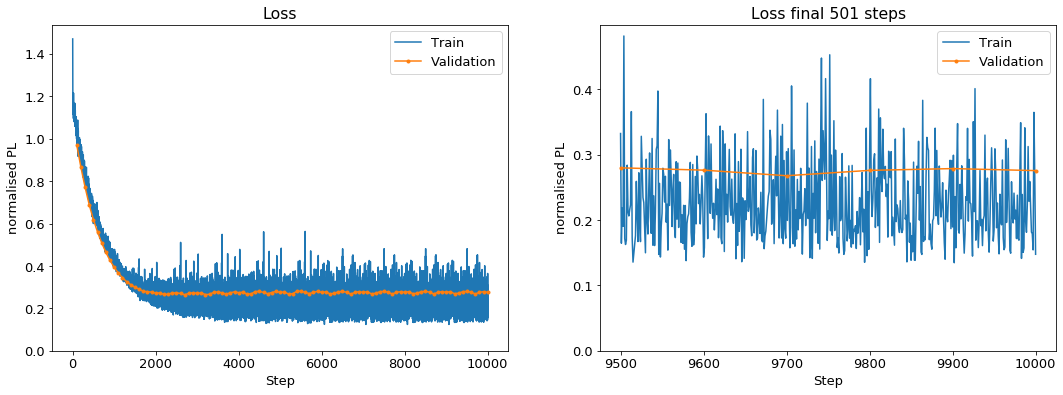

100/100 [==============================] - 3s 31ms/step - loss: 0.2222 - q0_loss: 0.0017 - q1_loss: 0.0067 - q2_loss: 0.0253 - q3_loss: 0.0330 - q4_loss: 0.0490 - q5_loss: 0.0477 - q6_loss: 0.0404 - q7_loss: 0.0136 - q8_loss: 0.0049 - val_loss: 0.2757 - val_q0_loss: 0.0021 - val_q1_loss: 0.0085 - val_q2_loss: 0.0349 - val_q3_loss: 0.0433 - val_q4_loss: 0.0562 - val_q5_loss: 0.0547 - val_q6_loss: 0.0484 - val_q7_loss: 0.0189 - val_q8_loss: 0.0086
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.5455601054055803, 'WSPL': 0.5455601054055803}


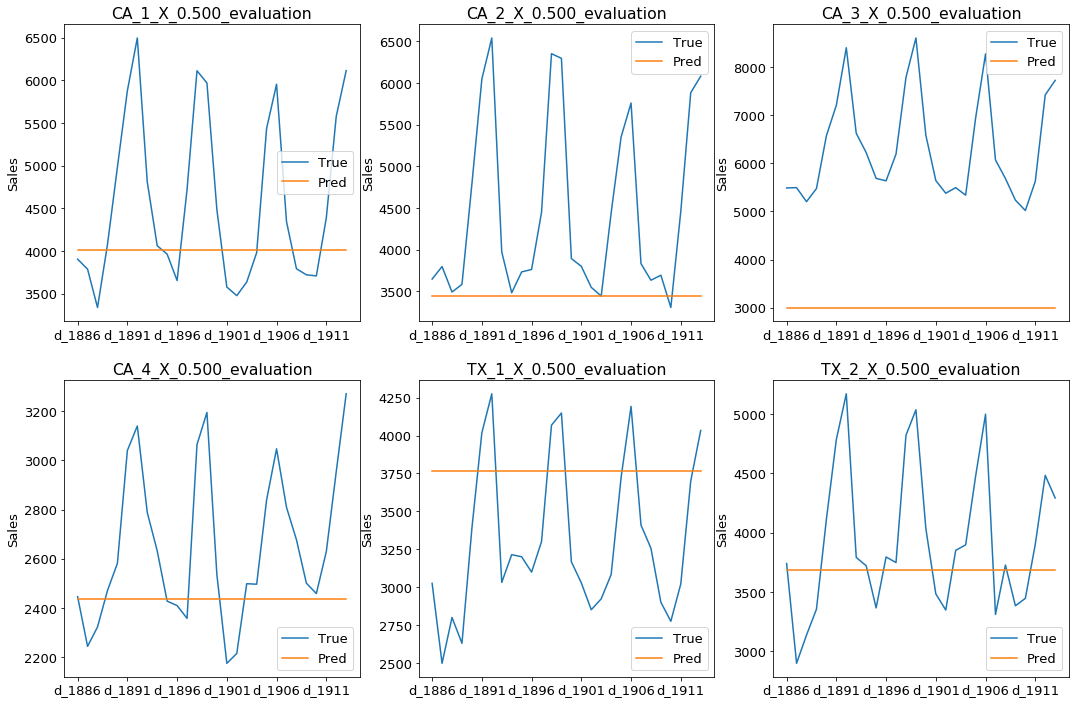

In [88]:
def line_search_param(params_idx, options, hyperparameter):
    print("Optimising {}".format(hyperparameter))
    params = get_params(params_idx, options)
    res = []
    
    for idx, val in enumerate(options[hyperparameter]):
        # set new parameter
        new_params = params.copy()
        new_params[hyperparameter] = val
        
        # train model
        model, logger, metrics1, metrics2, metrics3 = train_model_from_params(new_params, level, ref, 
                                                                              calendar, model_dir)
        
        res.append((new_params, [logger, metrics1, metrics2, metrics3]))
    return res

res = line_search_param(params_idx, options, "n0")

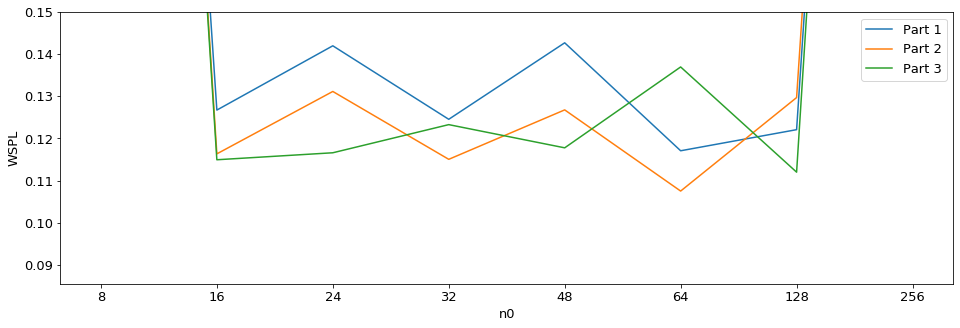

In [94]:
def plot_line_search_results(res, hyperparameter, ymax=None):
    options = []
    m1, m2, m3 = [], [], []
    for (new_params, [logger, metrics1, metrics2, metrics3]) in res:
        options.append(new_params[hyperparameter])
        m1.append(metrics1['WSPL'])
        m2.append(metrics2['WSPL'])
        m3.append(metrics3['WSPL'])
    
    f, ax = plt.subplots(1, 1, figsize=(16, 5))
    ax.plot(range(len(options)), m1, label="Part 1")
    ax.plot(range(len(options)), m2, label="Part 2")
    ax.plot(range(len(options)), m3, label="Part 3")
    ax.set_xticks(range(len(options)))
    ax.set_xticklabels(options)
    ax.set_xlabel(hyperparameter)
    ax.set_ylabel("WSPL")
    ax.set_ylim(top=ymax)
    ax.legend()
    plt.show()

plot_line_search_results(res, hyperparameter="n0", ymax=0.15)

In [95]:
results.extend(res)

**Choose: n0=16**

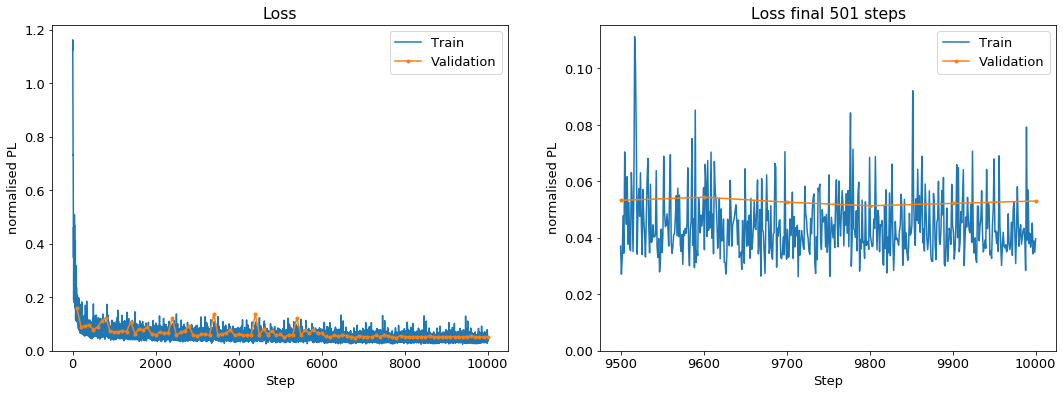

100/100 [==============================] - 2s 24ms/step - loss: 0.0433 - q0_loss: 4.0244e-04 - q1_loss: 0.0015 - q2_loss: 0.0061 - q3_loss: 0.0079 - q4_loss: 0.0100 - q5_loss: 0.0083 - q6_loss: 0.0067 - q7_loss: 0.0019 - q8_loss: 6.0698e-04 - val_loss: 0.0530 - val_q0_loss: 4.1650e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0080 - val_q3_loss: 0.0101 - val_q4_loss: 0.0126 - val_q5_loss: 0.0098 - val_q6_loss: 0.0078 - val_q7_loss: 0.0020 - val_q8_loss: 5.1529e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.10409895910114793, 'WSPL': 0.10409895910114793}


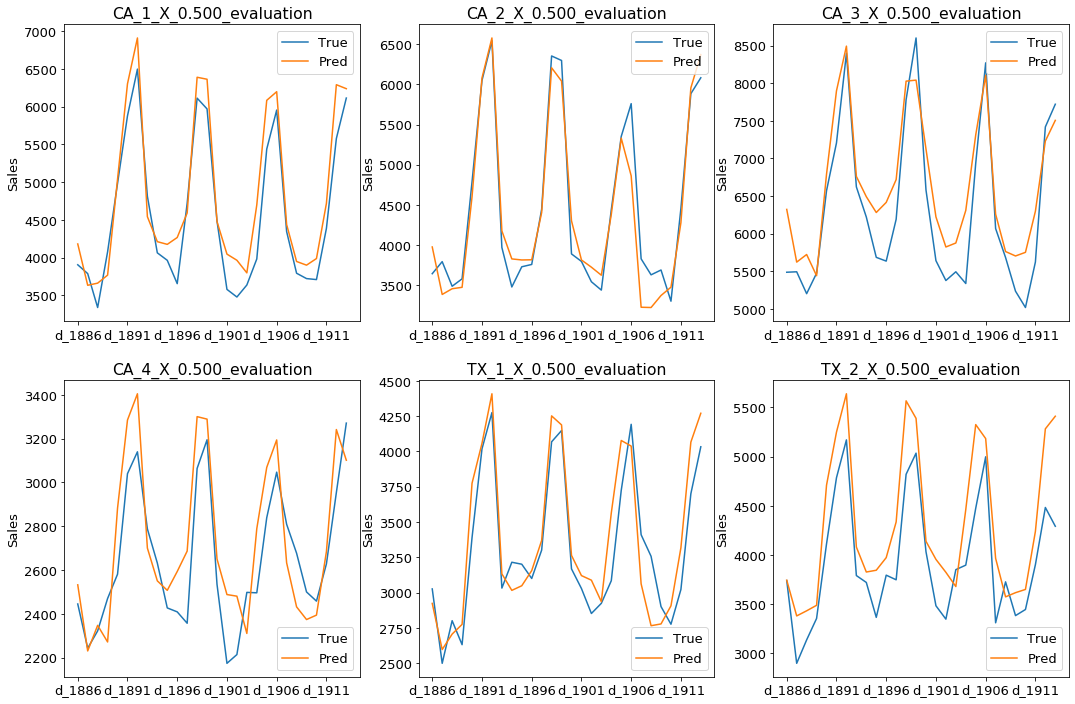

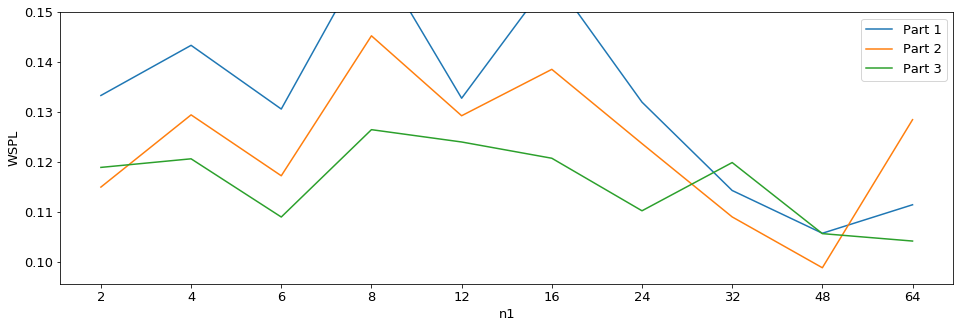

In [97]:
def optimise_and_store(params_idx, options, hyperparameter, results, clear=True):
    res = line_search_param(params_idx, options, hyperparameter)
    results.extend(res)
    clear_output() if clear else None
    plot_line_search_results(res, hyperparameter=hyperparameter, ymax=0.15)

hyperparameter = "n1"
optimise_and_store(params_idx, options, hyperparameter, results)

**Increase n1, but not past n0: new n1=16**

In [99]:
params_idx["n1"] = options["n1"].index(16)
params = get_params(params_idx, options, verbose=True)

Params:  {'mode': 'dist2', 'n0': 16, 'n1': 16, 'dropout_rate': 0, 'warmup_batch_size': 16, 'finetune_batch_size': 16, 'lgb_prediction': True}


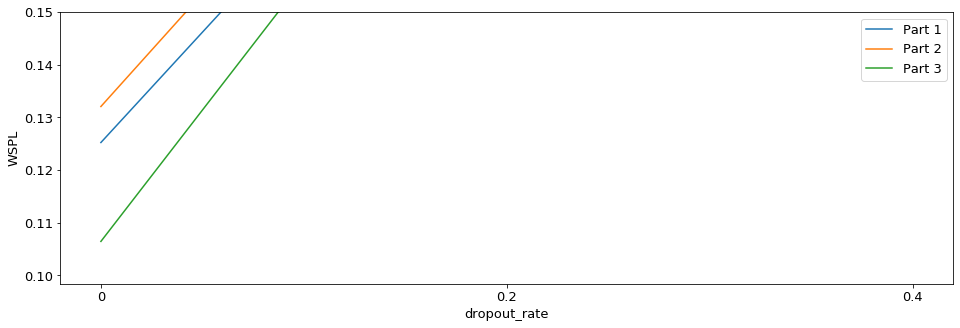

In [105]:
hyperparameter = "dropout_rate"
optimise_and_store(params_idx, options, hyperparameter, results)

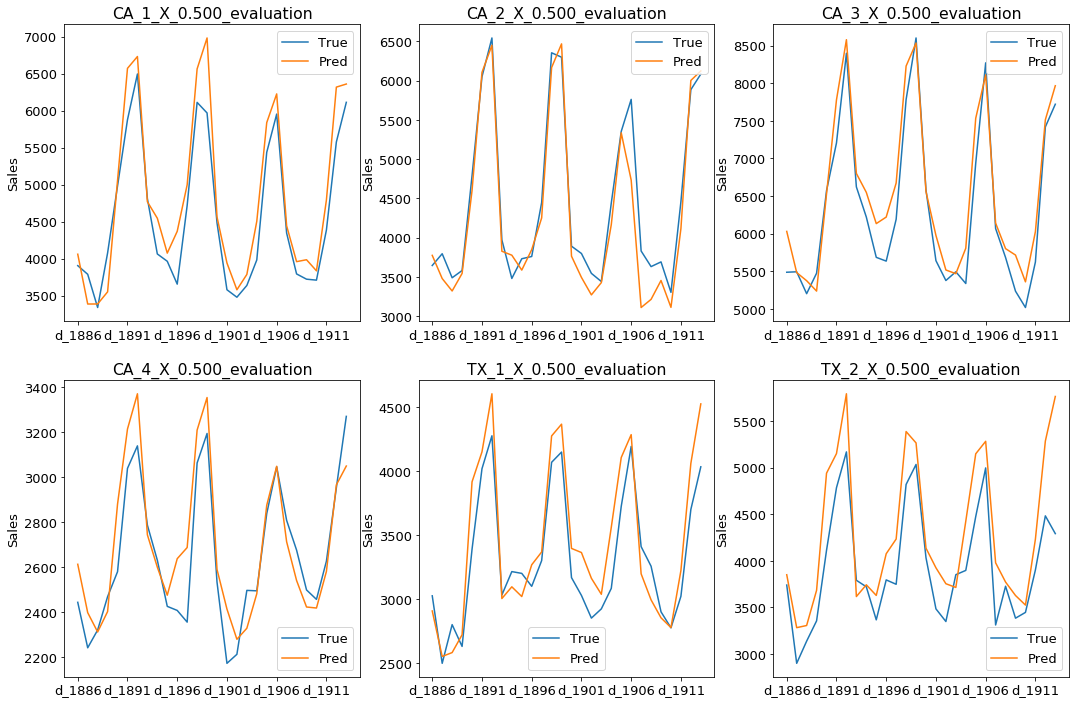

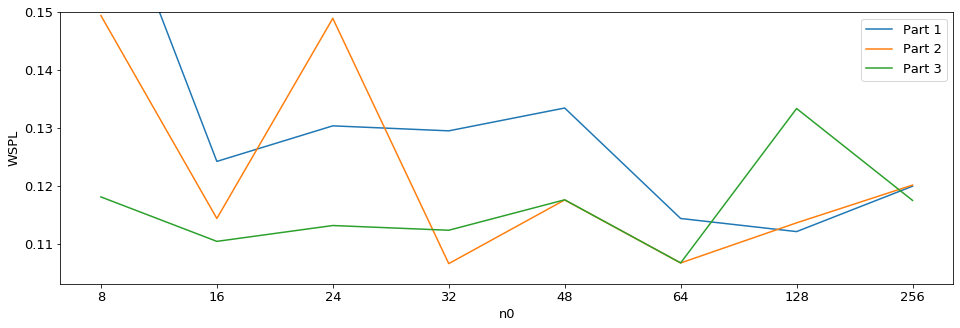

In [107]:
hyperparameter = "n0"
optimise_and_store(params_idx, options, hyperparameter, results)

In [ ]:
hyperparameter = "finetune_batch_size"
optimise_and_store(params_idx, options, hyperparameter, results)

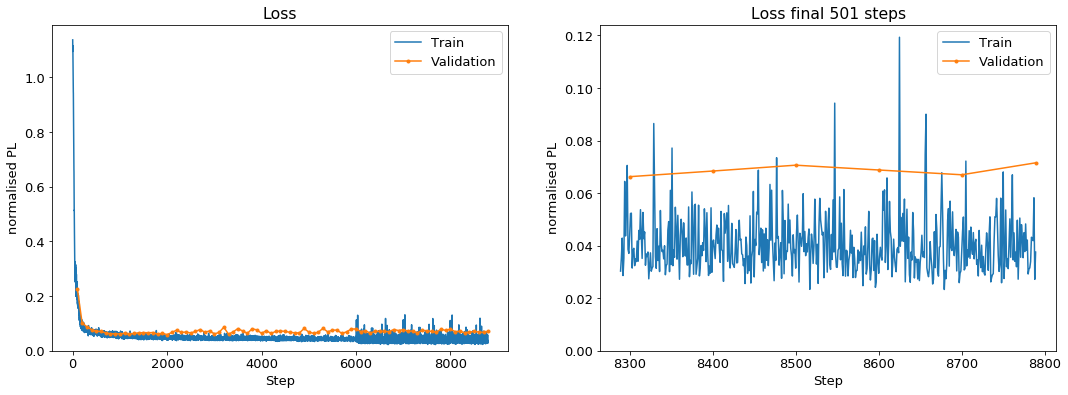

 90/100 [==========================>...] - ETA: 0s - loss: 0.0398 - q0_loss: 4.1507e-04 - q1_loss: 0.0015 - q2_loss: 0.0059 - q3_loss: 0.0074 - q4_loss: 0.0093 - q5_loss: 0.0074 - q6_loss: 0.0059 - q7_loss: 0.0015 - q8_loss: 4.1797e-04

KeyboardInterrupt: 

In [106]:
hyperparameter = "warmup_batch_size"
optimise_and_store(params_idx, options, hyperparameter, results)

In [9]:
n0 = 32
n1 = 48
n2 = 64
# select which model function was used to build the model
models_base = {
    1: get_trechter_model(inp_shape=input_shapes[1], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    2: get_trechter_model(inp_shape=input_shapes[2], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    3: get_trechter_model(inp_shape=input_shapes[3], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    4: get_trechter_model(inp_shape=input_shapes[4], num_nodes_start=n0, num_nodes_end=6, clear_session=False),
    5: get_trechter_model(inp_shape=input_shapes[5], num_nodes_start=n0, num_nodes_end=8, clear_session=False),
    6: get_trechter_model(inp_shape=input_shapes[6], num_nodes_start=n0, num_nodes_end=8, clear_session=False),
    7: get_trechter_model(inp_shape=input_shapes[7], num_nodes_start=n1, num_nodes_end=8, clear_session=False),
    8: get_trechter_model(inp_shape=input_shapes[8], num_nodes_start=n1, num_nodes_end=9, clear_session=False),
    9: get_trechter_model(inp_shape=input_shapes[9], num_nodes_start=n2, num_nodes_end=20, clear_session=False),
}

Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 15, 11, 8, 6]
Trechter nodes:  [32, 16, 12, 10, 8]
Trechter nodes:  [32, 16, 12, 10, 8]
Trechter nodes:  [48, 22, 16, 11, 8]
Trechter nodes:  [48, 23, 17, 12, 9]
Trechter nodes:  [64, 36, 29, 24, 20]


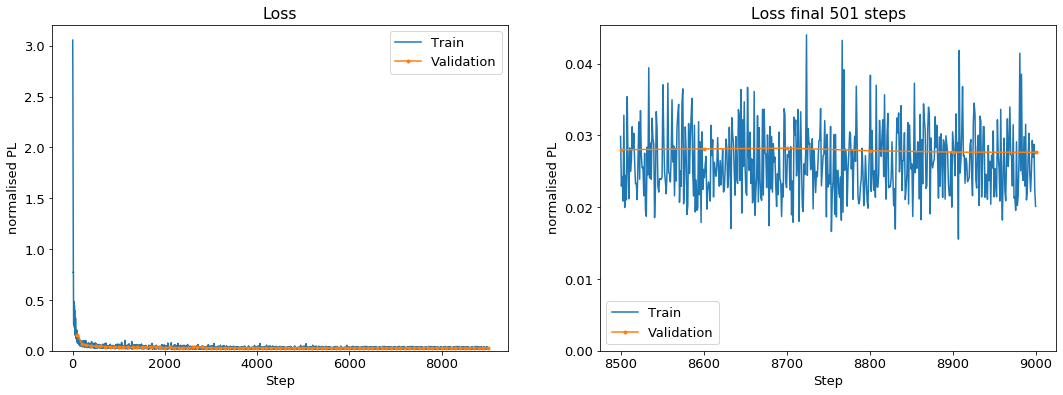

100/100 [==============================] - 4s 39ms/step - loss: 0.0265 - q0_loss: 2.3414e-04 - q1_loss: 8.6816e-04 - q2_loss: 0.0036 - q3_loss: 0.0047 - q4_loss: 0.0061 - q5_loss: 0.0052 - q6_loss: 0.0042 - q7_loss: 0.0012 - q8_loss: 3.7936e-04 - val_loss: 0.0276 - val_q0_loss: 2.5021e-04 - val_q1_loss: 9.2082e-04 - val_q2_loss: 0.0038 - val_q3_loss: 0.0050 - val_q4_loss: 0.0065 - val_q5_loss: 0.0054 - val_q6_loss: 0.0044 - val_q7_loss: 0.0011 - val_q8_loss: 3.3015e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.1395312136891781, 'WSPL': 0.1395312136891781}


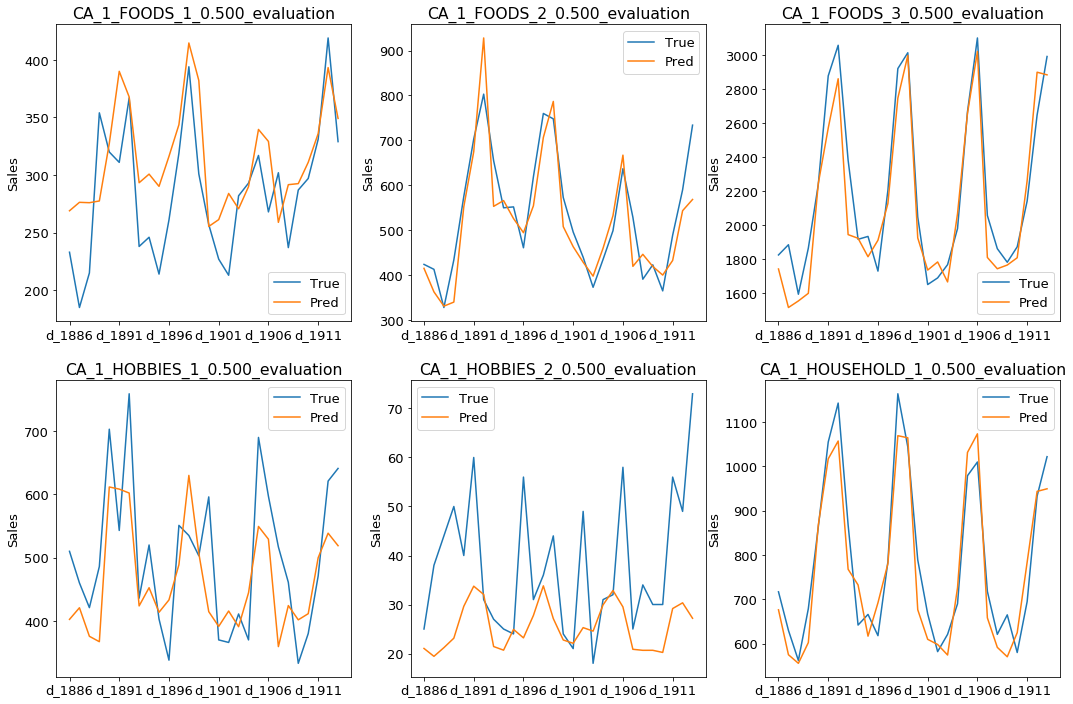

In [10]:
logger_list = []
part1_metrics = []
part2_metrics = []
part3_metrics = []

for level, model in models_base.items():
    # select model
    model = models_base[level]
    model_name = "model_trechter_{}_{}".format(mode, num_nodes)
    
    # train model
    warmup_lr_list = [1e-3, 1e-3, 1e-3,  # save part 1
                      1e-3, 1e-3, 1e-3]  # save part 2
    finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5] # save part 3
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, model_name=model_name, warmup_lr_list=warmup_lr_list,
        finetune_lr_list=finetune_lr_list, lgb_prediction=lgb_prediction,
        lgb_prediction_dir=lgb_prediction_dir, augment_events=augment_events,
    )
    
    # save metrics
    logger_list.append(logger)
    part1_metrics.append(metrics1)
    part2_metrics.append(metrics2)
    part3_metrics.append(metrics3)
    for i, m in enumerate([part1_metrics, part2_metrics, part3_metrics]):
        save_object(m, model_dir + mode + "_part{}_metrics.pickle".format(i + 1))

    # save training metrics
    save_object(logger.train_metrics, model_dir + model_name + "_metrics_train.pickle")
    save_object(logger.val_metrics, model_dir + model_name + "_metrics_val.pickle")

In [11]:
part1_metrics

[{1: 0.11258763097107721, 'WSPL': 0.11258763097107721},
 {2: 0.11197194719370862, 'WSPL': 0.11197194719370862},
 {3: 0.1262847455370582, 'WSPL': 0.1262847455370582},
 {4: 0.08395598927736261, 'WSPL': 0.08395598927736261},
 {5: 0.1332696138728708, 'WSPL': 0.1332696138728708},
 {6: 0.11981652883217005, 'WSPL': 0.11981652883217005},
 {7: 0.13370971308013424, 'WSPL': 0.13370971308013424},
 {8: 0.13871274089004296, 'WSPL': 0.13871274089004296},
 {9: 0.14783097647782062, 'WSPL': 0.14783097647782062}]

In [12]:
part2_metrics

[{1: 0.11482423284821627, 'WSPL': 0.11482423284821627},
 {2: 0.10907895062460973, 'WSPL': 0.10907895062460973},
 {3: 0.12222097363958769, 'WSPL': 0.12222097363958769},
 {4: 0.08561621238131548, 'WSPL': 0.08561621238131548},
 {5: 0.11269479193501727, 'WSPL': 0.11269479193501727},
 {6: 0.11538107728354705, 'WSPL': 0.11538107728354705},
 {7: 0.12634873956220985, 'WSPL': 0.12634873956220985},
 {8: 0.12813336378233095, 'WSPL': 0.12813336378233095},
 {9: 0.14357964532382272, 'WSPL': 0.14357964532382272}]

In [13]:
part3_metrics

[{1: 0.11699933266101492, 'WSPL': 0.11699933266101492},
 {2: 0.10853823975491592, 'WSPL': 0.10853823975491592},
 {3: 0.11953225546045246, 'WSPL': 0.11953225546045246},
 {4: 0.08681495378644613, 'WSPL': 0.08681495378644613},
 {5: 0.11263533444064994, 'WSPL': 0.11263533444064994},
 {6: 0.1161957314258048, 'WSPL': 0.1161957314258048},
 {7: 0.1260546575337832, 'WSPL': 0.1260546575337832},
 {8: 0.13034320607918895, 'WSPL': 0.13034320607918895},
 {9: 0.1395312136891781, 'WSPL': 0.1395312136891781}]

In [14]:
for i, metrics in enumerate([part1_metrics, part2_metrics, part3_metrics]):
    save_object(metrics, model_dir + "metrics_ref_part{}.pickle".format(i+1))

for i, logger in enumerate(logger_list):
    save_object(logger.train_metrics, model_dir + "metrics_train_level{}.pickle".format(i+1))
    save_object(logger.val_metrics, model_dir + "metrics_val_level{}.pickle".format(i+1))

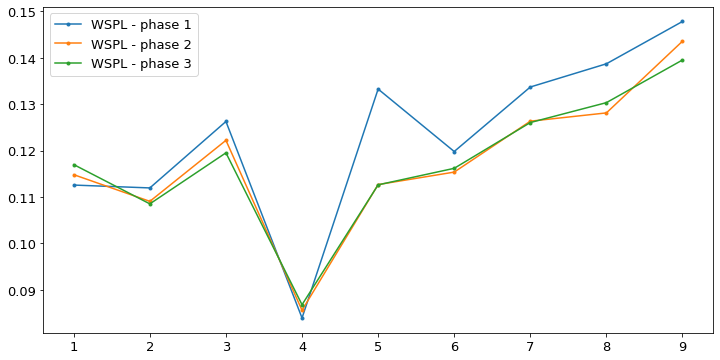

In [15]:
part1_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part1_metrics}
part2_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part2_metrics}
part3_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part3_metrics}

f, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, metrics in enumerate([part1_WSPL, part2_WSPL, part3_WSPL]):
    ax.plot(list(metrics.keys()), list(metrics.values()), '.-', label="WSPL - phase {}".format(i+1))
ax.legend()
plt.show()

Level 1


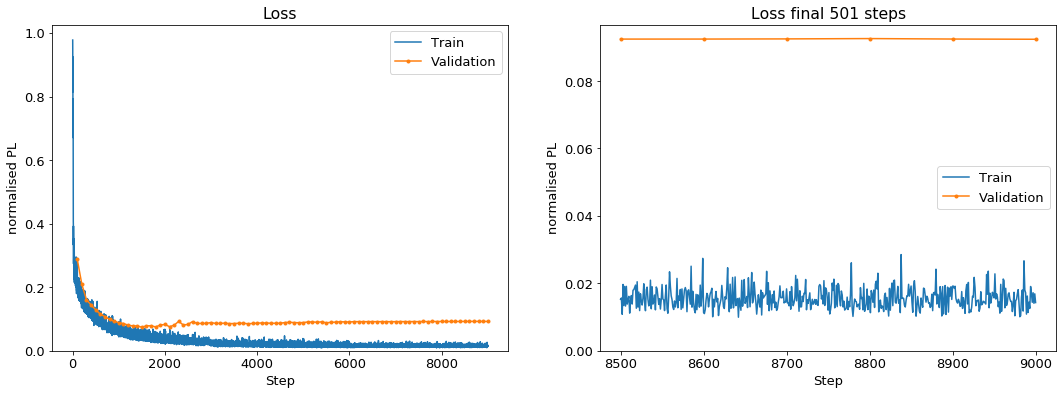

Level 2


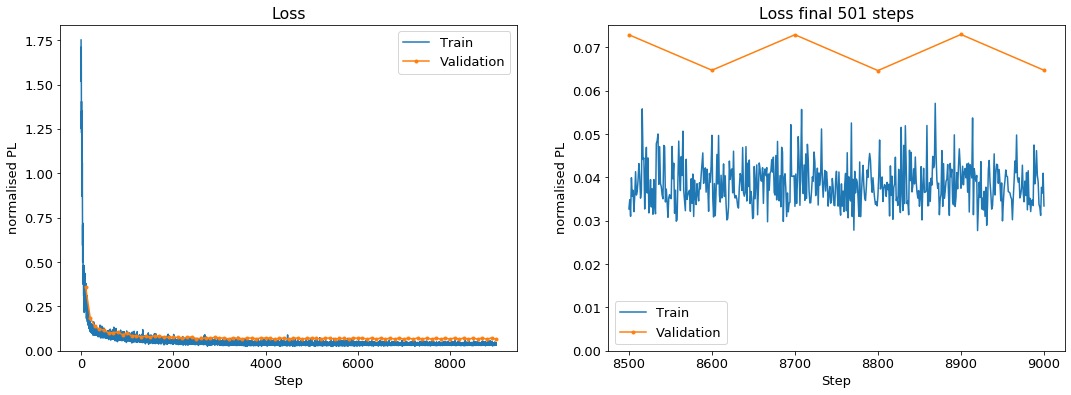

Level 3


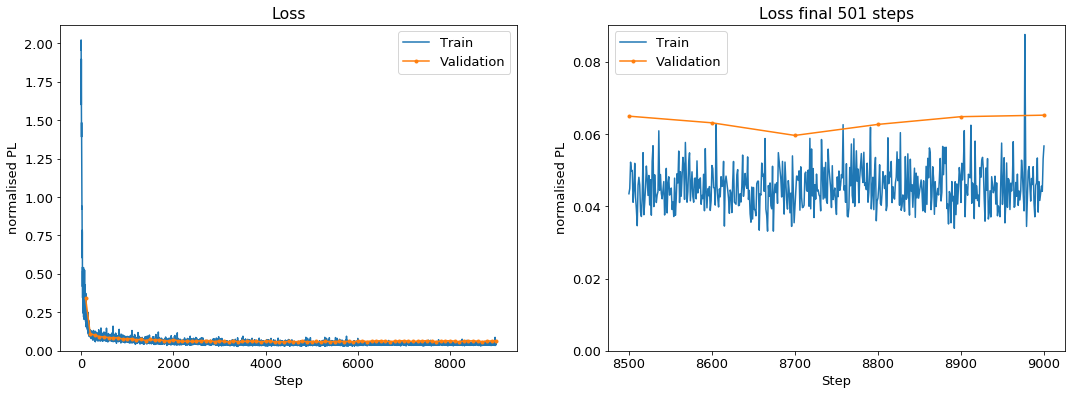

Level 4


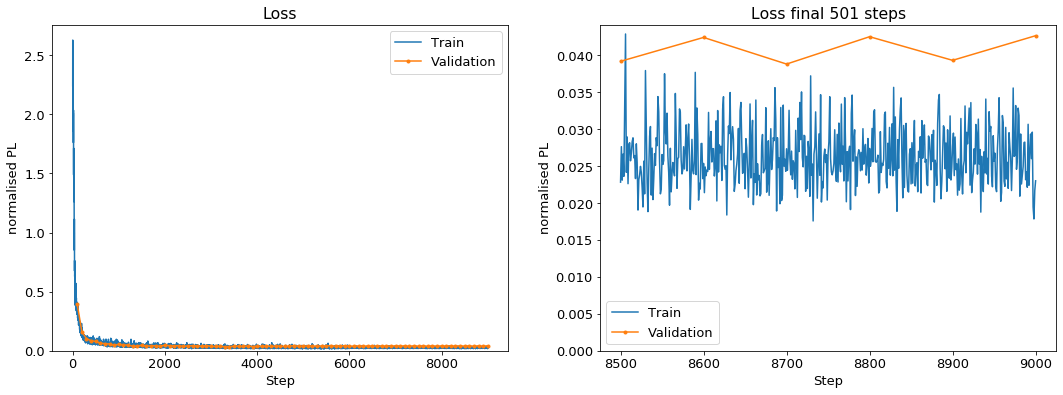

Level 5


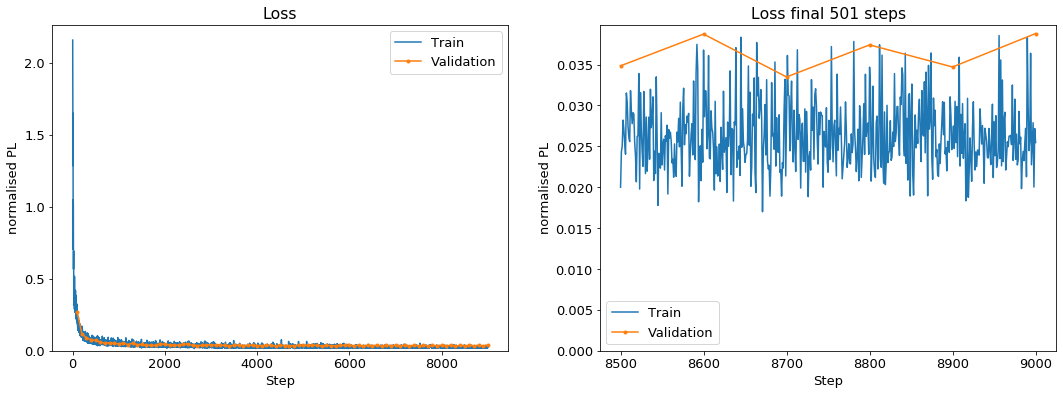

Level 6


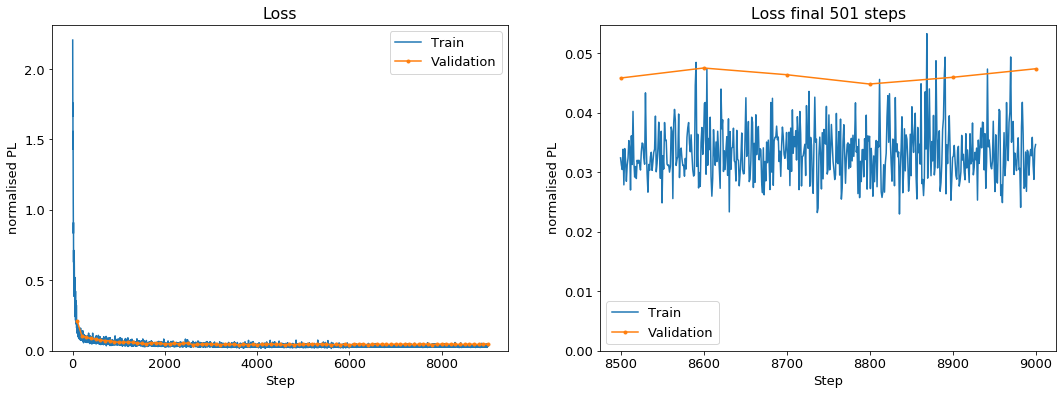

Level 7


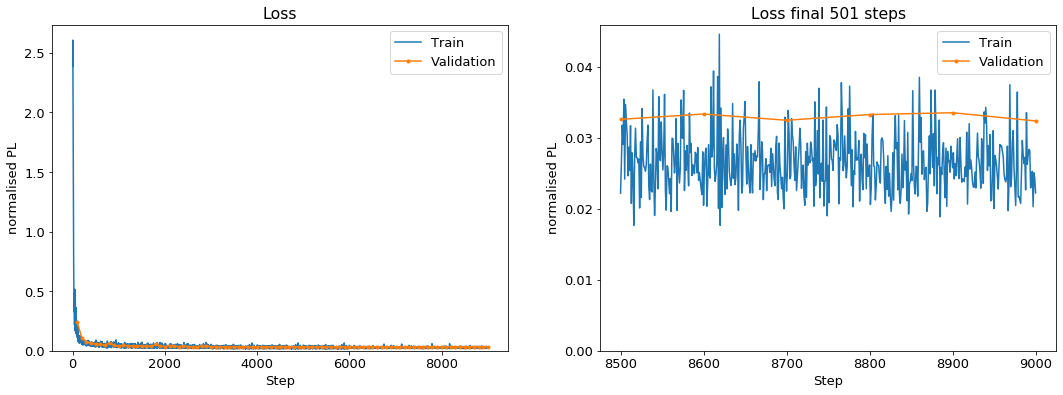

Level 8


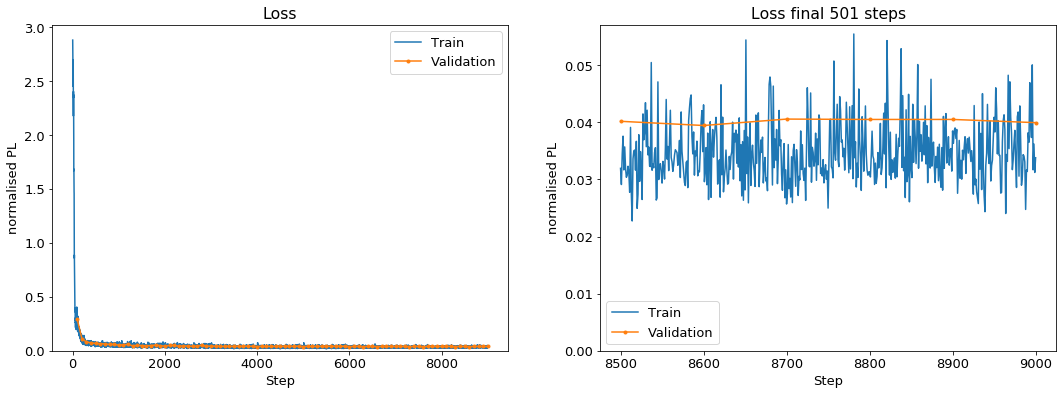

Level 9


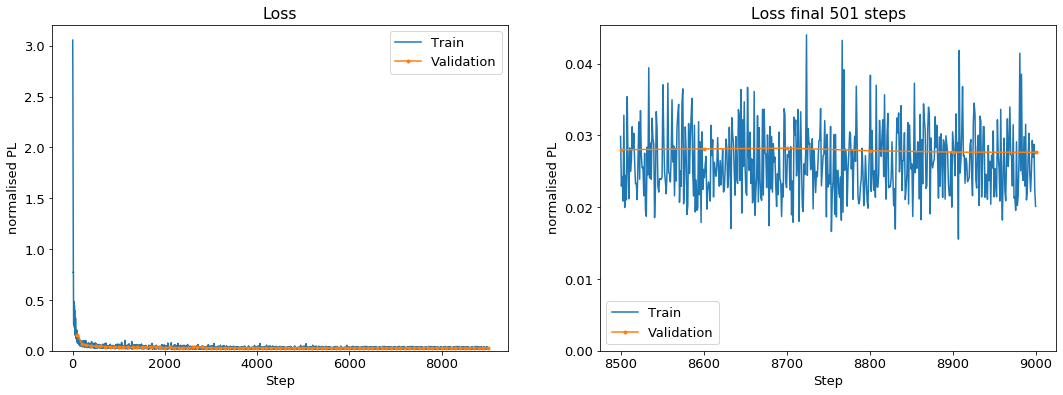

In [16]:
for i, logger in enumerate(logger_list):
    print("Level {}".format(i+1))
    logger.plot(clear=False)

### Finetune lr

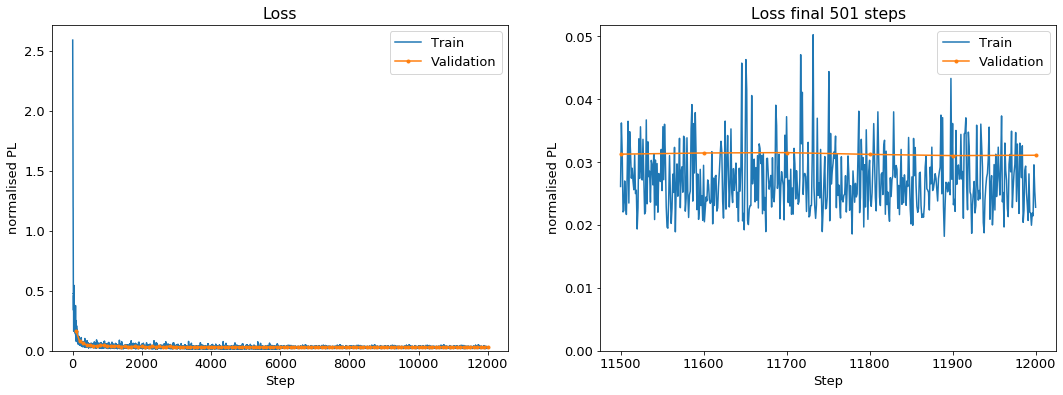

100/100 [==============================] - 4s 38ms/step - loss: 0.0269 - q0_loss: 2.5622e-04 - q1_loss: 8.7733e-04 - q2_loss: 0.0037 - q3_loss: 0.0047 - q4_loss: 0.0062 - q5_loss: 0.0053 - q6_loss: 0.0043 - q7_loss: 0.0013 - q8_loss: 4.0002e-04 - val_loss: 0.0311 - val_q0_loss: 2.7499e-04 - val_q1_loss: 0.0010 - val_q2_loss: 0.0046 - val_q3_loss: 0.0058 - val_q4_loss: 0.0072 - val_q5_loss: 0.0058 - val_q6_loss: 0.0047 - val_q7_loss: 0.0013 - val_q8_loss: 4.0578e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.15642933540576054, 'WSPL': 0.15642933540576054}


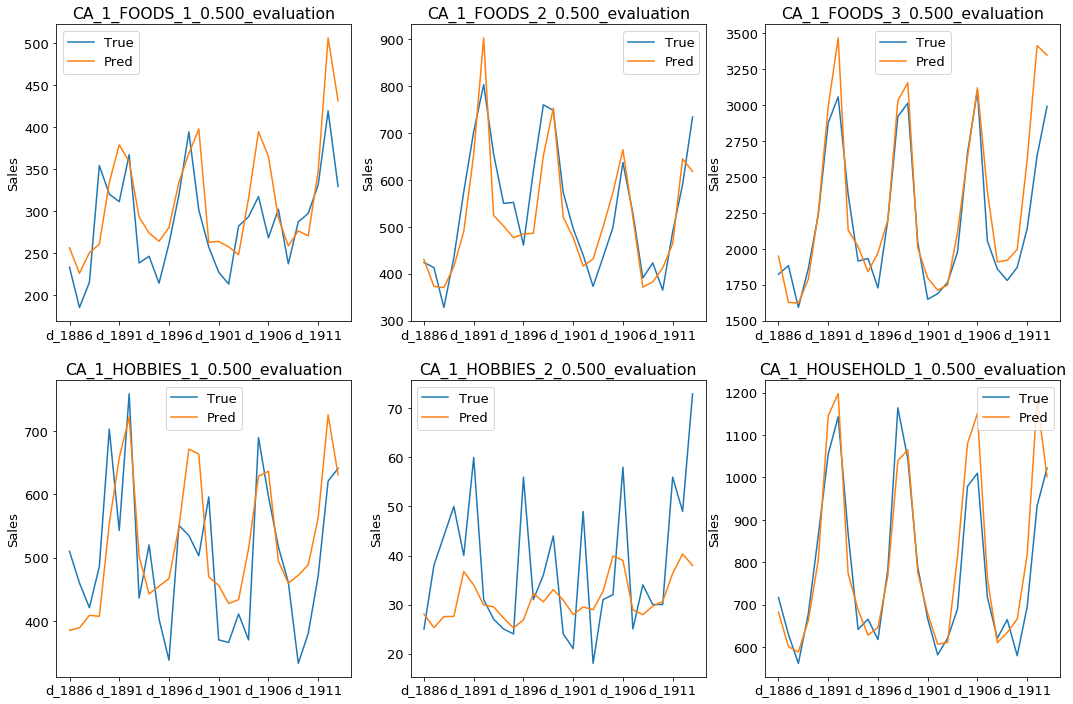

In [17]:
level = 9
finetune_batch_size = {level: 64 for level in range(1, 1+12)}
options = [[1e-5, 1e-6, 1e-7],
          [1e-5, 1e-5, 1e-6, 1e-6, 1e-7, 1e-7]]
logger_list = []
part1_metrics = []
part2_metrics = []
part3_metrics = []

for finetune_lr_list in options:
    # build model
    model = get_trechter_model(inp_shape=input_shapes[level], num_nodes_start=n1, num_nodes_end=16, clear_session=True)

    # train model
    warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                      1e-4, 1e-4, 1e-4] # save part 2
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, model_name="level9_lr3-is-{}".format(finetune_lr_list[2]), 
        warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list
    )
    
    # save metrics
    logger_list.append(logger); part1_metrics.append(metrics1); 
    part2_metrics.append(metrics2); part3_metrics.append(metrics3)

In [18]:
part1_metrics

[{9: 0.1575618153682754, 'WSPL': 0.1575618153682754},
 {9: 0.17477056002735816, 'WSPL': 0.17477056002735816}]

In [19]:
part2_metrics

[{9: 0.15186003799899653, 'WSPL': 0.15186003799899653},
 {9: 0.16573511268501576, 'WSPL': 0.16573511268501576}]

In [20]:
part3_metrics

[{9: 0.15247829982845787, 'WSPL': 0.15247829982845787},
 {9: 0.15642933540576054, 'WSPL': 0.15642933540576054}]

In [21]:
for i, metrics in enumerate([part1_metrics, part2_metrics, part3_metrics]):
    save_object(metrics, model_dir + "metrics_ref_lr_part{}.pickle".format(i+1))

for i, logger in enumerate(logger_list):
    save_object(logger.train_metrics, model_dir + "metrics_train_lr_level{}.pickle".format(i+1))
    save_object(logger.val_metrics, model_dir + "metrics_val_lr_level{}.pickle".format(i+1))

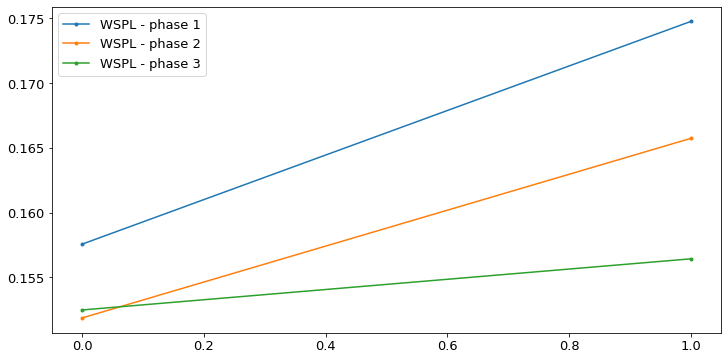

In [22]:
labels = ['short', 'long']
part1_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part1_metrics)}
part2_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part2_metrics)}
part3_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part3_metrics)}

f, ax = plt.subplots(1, 1, figsize=(12, 6))
n = len(part1_WSPL)
for i, metrics in enumerate([part1_WSPL, part2_WSPL, part3_WSPL]):
    ax.plot(range(n), list(metrics.values()), '.-', label="WSPL - phase {}".format(i+1))
ax.set_xticks(range(n), labels)
ax.legend()
plt.show()

Lr list [1e-05, 1e-06, 1e-07]


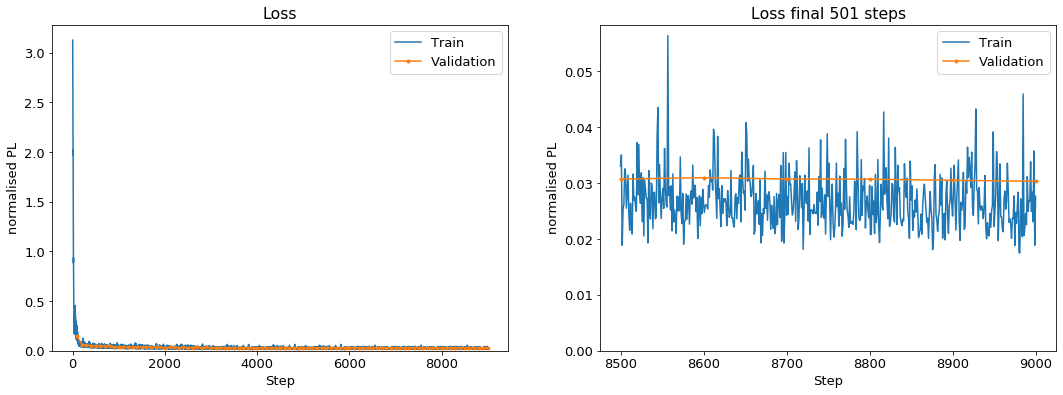

Lr list [1e-05, 1e-05, 1e-06, 1e-06, 1e-07, 1e-07]


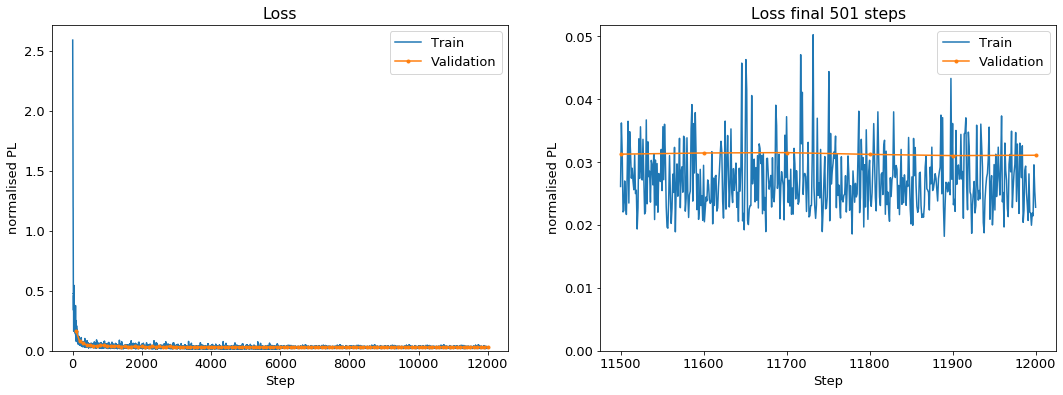

In [23]:
for i, logger in enumerate(logger_list):
    print("Lr list {}".format(options[i]))
    logger.plot(clear=False)